### An Adaptive Runge-Kutta Integrator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derivs_orbit(t, x):
    """
    Calculate the derivatives, code from in class exercise
    """
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))


def rk4(nsteps, x0, derivs):
    """
    Regular RK4, code from in class exercise
    """
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    dt = 2 * np.pi / (nsteps-1)
    for i in range(1,nsteps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)
        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x

def next_rk4(x, y, dt, derivs):
    """
    Compute the next RK4 step
    """
    f = derivs(x, y)
    f1 = derivs(x + dt/2, y + f*dt/2)
    f2 = derivs(x + dt/2, y + f1*dt/2)
    f3 = derivs(x+dt, y + f2*dt)
    return y + dt*(f + 2*f1 + 2*f2 + f3)/6

def rk4_adaptive(dt, x0, eps, derivs):
    """
    Adaptive RK4 integrator
    """
    t = 0
    x = [x0]
    
    while t < 2*np.pi:
        res = next_rk4(t, x[-1], dt, derivs)  # Take step dt
        compare = next_rk4(t, x[-1], dt/2, derivs)
        compare = next_rk4(t+dt/2, compare, dt/2, derivs)  # Take 2 steps dt/2
        
        # Compare relative error to tolerance
        # Decrease dt if error too large
        if 2*abs((res[0] - compare[0])/(res[0] + compare[0])) < eps:
            t += dt  # Update time
            
            # If overshoot, revert and calculate correct dt
            # Else accept result and increase dt
            if t > 2*np.pi:
                t -= dt
                dt = 2*np.pi - t
                break
            
            else:
                x.append(res)
                dt *= 2
        else:
            dt /= 2
            
    # Last step of integration with the right dt
    x.append(next_rk4(t, x[-1], dt, derivs)) 
    return np.array(x)

Text(0, 0.5, 'y')

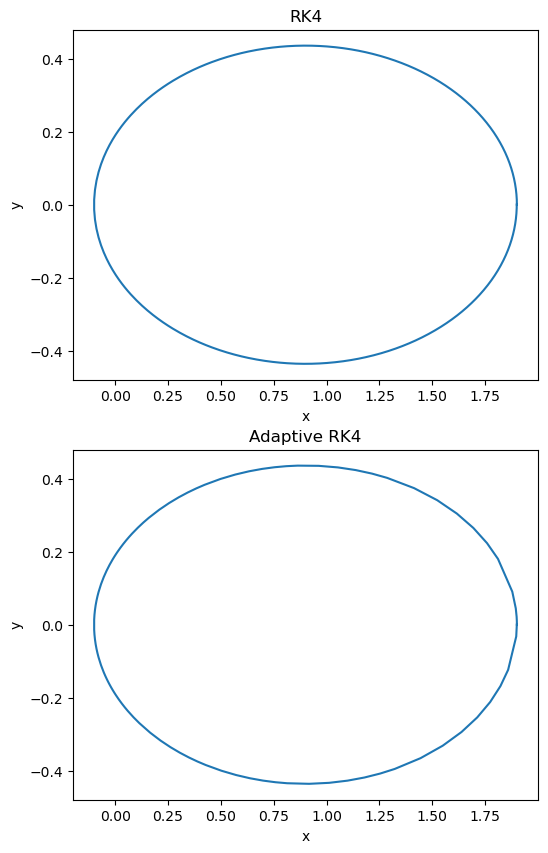

In [4]:
# Check if both integrate to an elliptical orbit

e = 0.9

# RK4
nsteps = 10**3
x_start = np.array((1+e,0,0,(2/(e+1)-1)**0.5))
x4 = rk4(nsteps, x_start, derivs_orbit)

# Adaptive RK4
x5 = rk4_adaptive(2*np.pi/nsteps, x_start, 10**-6, derivs_orbit)


# Plotting
figure = plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
plt.plot(x4[:,0], x4[:,1])
plt.title("RK4")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(2,1,2)
plt.plot(x5[:,0], x5[:,1])
plt.title("Adaptive RK4")
plt.xlabel("x")
plt.ylabel("y")

Both methods yield similar elliptical orbits. Now let's compare the number of steps needed to achieve an accuracy of $10^{-6}$.

[]

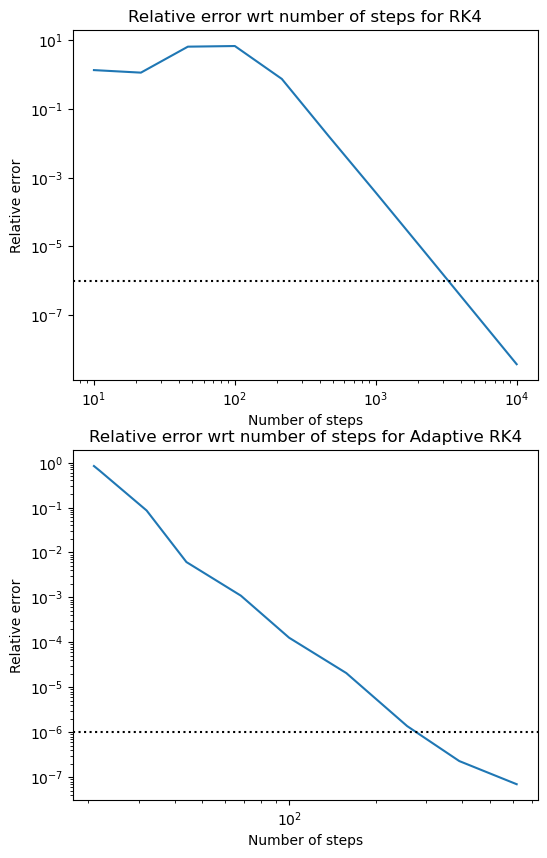

In [5]:
# RK4
steps = np.logspace(1, 4, 10)
err_rk4 = []
for step in steps:
    err_rk4.append(abs(rk4(int(step), x_start, derivs_orbit)[-1][0] - 1.9)/1.9)
    
    
# Adaptive RK4
tolerance = np.logspace(-10, -1, 10)
num_steps = []
err_ark4 = []
for eps in tolerance:
    res = rk4_adaptive(0.01, x_start, eps, derivs_orbit)
    err_ark4.append(abs(res[-1][0] - 1.9)/1.9)
    num_steps.append(len(res))

    
# Plotting
figure = plt.figure(figsize=(6, 10))
plt.subplot(2,1,1)
plt.plot(steps, err_rk4)
plt.axhline(y=10**-6, color='k', linestyle=':')
plt.title("Relative error wrt number of steps for RK4")
plt.xlabel("Number of steps")
plt.ylabel("Relative error")
plt.loglog()

plt.subplot(2,1,2)
plt.plot(num_steps, err_ark4)
plt.axhline(y=10**-6, color='k', linestyle=':')
plt.title("Relative error wrt number of steps for Adaptive RK4")
plt.xlabel("Number of steps")
plt.ylabel("Relative error")
plt.loglog()

We can clearly see from the plots that with an adaptive step size, we can achieve an accuracy of $10^{-6}$ with about 10 times less steps.

### Method of Lines

The thermal diffusion equation that we consider is

\begin{equation}
    \frac{{\partial T}}{{\partial t}} = \frac{{\partial^2 T}}{{\partial x^2}}.
\end{equation}

We can rewrite the equation into an ODE using finite differencing

\begin{equation}
    \frac{dT_i}{dt} = \frac{T_{i+1}-2T_i+T_{i-1}}{(\Delta x)^2},
\end{equation}

and in matrix form:

\begin{equation}
    \frac{d\mathbf{T}}{dt} = \mathbf{AT},
\end{equation}

where $\mathbf{T}$ is a vector representing the temperatures and $\mathbf{A}$ is a tridiagonal matrix.

Using Backward-Euler and solving for $\mathbf{T}_{i+1}$, we get

\begin{equation}
    \mathbf{T}_{i+1} = \mathbf{T}_i + h \mathbf{AT}_{i+1}
\end{equation}

\begin{equation}
    (\mathbf{I} - h\mathbf{A})\mathbf{T}_{i+1} = \mathbf{T}_i
\end{equation}

\begin{equation}
    \mathbf{T}_{i+1} = (\mathbf{I} - h\mathbf{A})^{-1}\mathbf{T}_i.
\end{equation}

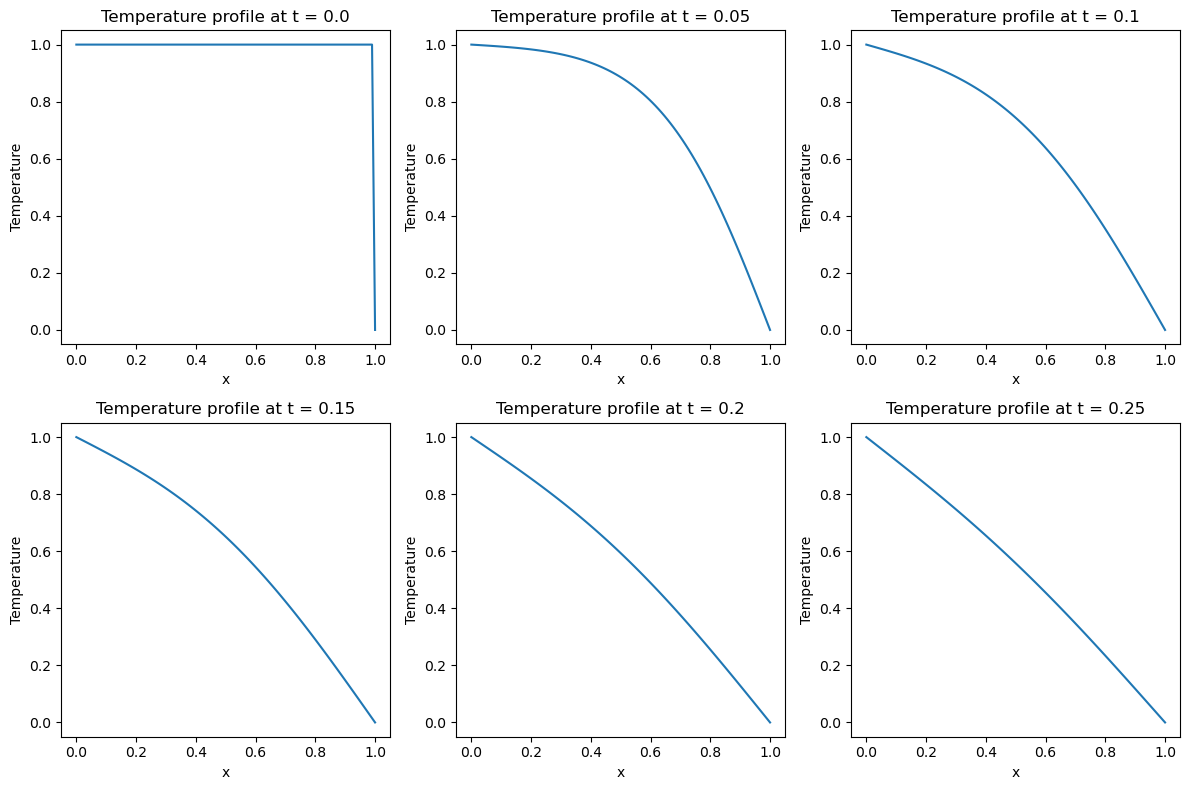

In [48]:
def integrate(t):
    # Create grid, initial temperature, steps and matrix A
    n = 100
    grid = np.linspace(0, 1, n)
    dx = 1/n
    T = np.ones(100)
    h = 0.01
    A = (np.diag(-2 * np.ones(n))
         + np.diag(np.ones(n - 1), 1)
         + np.diag(np.ones(n - 1), -1))

    # Set initial values and boundary conditions
    T[0] = 1
    T[-1] = 0
    A[0] = 0
    A[-1] = 0


    # Calculate the matrix expression and its inverse
    expression = np.identity(n) - h * A / dx**2
    U, Sdiag, VT = np.linalg.svd(expression, full_matrices=False)
    S = np.diag(1/Sdiag)
    inv = VT.T@S@U.T

    # Integrate in time
    for i in range(int(t/h)):
        T = inv@T

    return T

# Plotting
times = np.arange(0, 0.3, 0.05)
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, t in enumerate(times):
    T = integrate(t)
    axs[i//3, i%3].plot(x, T)
    axs[i//3, i%3].set_title("Temperature profile at t = " + str(round(t, 2)))
    axs[i//3, i%3].set_xlabel("x")
    axs[i//3, i%3].set_ylabel("Temperature")

plt.tight_layout()

This is expected. The boundary conditions are respected (fixed $T=1$ at $x=0$ and $T=0$ at $x=1$). As time progesses, we would expect the piece of metal to "smooth out" the temperature profile between the boundaries. After the system reaches equilibrium, the temperature no longer fluctuates, so the time dependence vanishes. The LHS of the thermal diffusion equation becomes $0$, which means that the change in temperature with respect to the position is linear. Again, this is observed in our plots for larger values of $t$.